In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import kde
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erfinv
from matplotlib.colors import LogNorm

smallFiles = False

#settings
plt.style.use('classic')
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 3.0
matplotlib.rcParams['hist.bins'] = 'auto'
matplotlib.rcParams['image.cmap'] = 'RdYlBu_r' #'hot'
#print(matplotlib.rcParams)

print("Hello world!")
folder= "../BigDataFiles/"
inputFile=folder+"ACP80_0_flt.dat"
inputSimFile=folder+"ACP80_plus50_flt.dat"
if (smallFiles):
    folder= "../DataFiles/"
    inputFile=folder+"ACP80_0_p100k.dat"
    inputSimFile=folder+"ACP80_plus50_p100k.dat"

inFileLabel=r"0 $\mu$rad"
inSimFileLabel=r"+50 $\mu$rad"

cols=["gonio_angle","d0_x","d0_y","thetaIn_x","thetaOut_x","thetaIn_y","thetaOut_y","unknown1","unknown2"]

#Common offset for ACP80 runs
gonio_zero = 1570840.0/1000. #mrad

Hello world!


In [15]:
def emittanceRMS(x,y):
    rmsX = np.std(x)
    rmsY = np.std(y)
    #print(np.corrcoef(x,y))
    det = np.linalg.det(np.corrcoef(x,y))
    #print(rmsX,rmsY,det)
    return rmsX*rmsY*math.sqrt(det)
    
def fracToSigma(f):
    return erfinv(f)*math.sqrt(2.)
def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
def GaussFunc(x,A,mu,sigma):
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))/(np.sqrt(2*math.pi)*sigma))

def plot2D(ax,x,y,xlabel,ylabel,bins,rng,cmap):
    ax.hist2d(x, y, bins=bins,range=rng,  cmap=cmap)
    ax.set_xlabel(xlabel, fontsize='20')
    ax.set_ylabel(ylabel, fontsize='20')
    val=999.
    return val

def plot1D(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    if log: ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng)
    ax.legend(loc= "best")
#    ax.legend(loc= "lower right")


def plot1DNorm(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng, density=True)
    ax.legend(loc= "lower right")

In [4]:
if inputSimFile == "":
    simu = data
else :
    simu = np.genfromtxt(inputSimFile,
                         names=cols,
                         dtype=None,
                         delimiter=',')

datasetI = pd.read_csv(inputFile,header=None,names=cols)
datasetI["gonio_angle"]=datasetI["gonio_angle"]/1000.
datasetI["thetaIn_x"]=datasetI["thetaIn_x"]*1000.
datasetI["thetaOut_x"]=datasetI["thetaOut_x"]*1000.
datasetI["thetaIn_y"]=datasetI["thetaIn_y"]*1000.
datasetI["thetaOut_y"]=datasetI["thetaOut_y"]*1000.
datasetI["deltaTheta"] = datasetI["thetaOut_x"]-datasetI["thetaIn_x"]
print(datasetI.iloc[0,:])

if inputSimFile == "":
    datasetSimuI = datasetI
else :
    datasetSimuI = pd.read_csv(inputSimFile,header=None,names=cols)
    datasetSimuI["gonio_angle"]=datasetSimuI["gonio_angle"]/1000.
    datasetSimuI["thetaIn_x"]=datasetSimuI["thetaIn_x"]*1000.
    datasetSimuI["thetaOut_x"]=datasetSimuI["thetaOut_x"]*1000.
    datasetSimuI["thetaIn_y"]=datasetSimuI["thetaIn_y"]*1000.
    datasetSimuI["thetaOut_y"]=datasetSimuI["thetaOut_y"]*1000.
    datasetSimuI["deltaTheta"] = datasetSimuI["thetaOut_x"]-datasetI["thetaIn_x"]
print(datasetSimuI.iloc[0,:])

gonio_angle    1570.840000
d0_x             -0.118649
d0_y             -0.246366
thetaIn_x        -0.007750
thetaOut_x        0.049916
thetaIn_y         0.018783
thetaOut_y        0.039124
unknown1          0.000000
unknown2          0.000000
deltaTheta        0.057666
Name: 0, dtype: float64
gonio_angle    1570.889900
d0_x             -0.669965
d0_y              0.131507
thetaIn_x        -0.017354
thetaOut_x       -0.014454
thetaIn_y         0.000661
thetaOut_y       -0.033385
unknown1          0.000000
unknown2          0.000000
deltaTheta       -0.006704
Name: 0, dtype: float64


In [5]:
#pass the initial dataset to the one you'll manipulate
dataset = datasetI

#clean from zeros
#dataset = dataset[dataset.d0_x != 0.0]
#dataset = dataset[dataset.d0_y != 0.0]

#define weights
dataset["weight"] = 1.

#pass the initial dataset to the one you'll manipulate
datasetSimu = datasetSimuI

#clean from zeros
#datasetSimu = datasetSimu[datasetSimu.d0_x != 0.0]
#datasetSimu = datasetSimu[datasetSimu.d0_y != 0.0]

#define weights
datasetSimu["weight"] = 1.

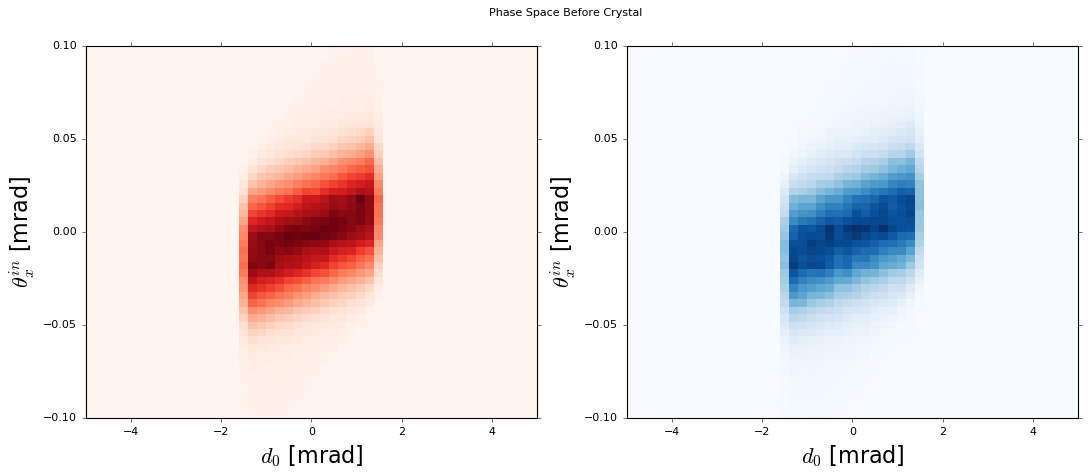

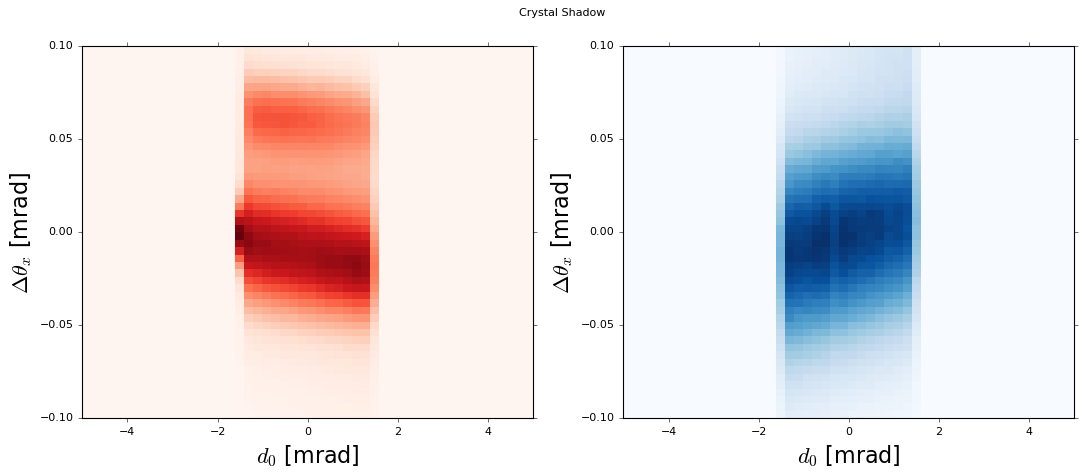

In [6]:
#fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80)
fig.suptitle("Phase Space Before Crystal")
plot2D(axes[0],
       dataset["d0_x"],
       dataset["thetaIn_x"],
       r"$d_0$ [mrad]",
       r"$\theta_x^{in}$ [mrad]",
       (50,50),
       [[-5.,5.],[-0.1,0.1]],
       "Reds"
      )
plot2D(axes[1],
       datasetSimu["d0_x"],
       datasetSimu["thetaIn_x"],
       r"$d_0$ [mrad]",
       r"$\theta_x^{in}$ [mrad]",
       (50,50),
       [[-5.,5.],[-0.1,0.1]],
       "Blues"
      )

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80)
fig.suptitle("Crystal Shadow")
plot2D(axes[0],
       dataset["d0_x"],
       dataset["deltaTheta"],
       r"$d_0$ [mrad]",
       r"$\Delta\theta_x$ [mrad]",
       (50,50),
       [[-5.,5.],[-0.1,0.1]],
       "Reds"
      )
plot2D(axes[1],
       datasetSimu["d0_x"],
       datasetSimu["deltaTheta"],
       r"$d_0$ [mrad]",
       r"$\Delta\theta_x$ [mrad]",
       (50,50),
       [[-5.,5.],[-0.1,0.1]],
       "Blues"
      )

plt.show()

In [7]:
applyCut = True
applyWeight = False
max_d0x = 1.
max_d0y = 2.
max_thetaInx = 0.015

if applyCut:
    #apply whatever selection you need
    dataset = dataset[abs(dataset.d0_x)<max_d0x]
    dataset = dataset[abs(dataset.d0_y)<max_d0y]
    dataset = dataset[abs(dataset.thetaIn_x)<max_thetaInx]


#pass the initial dataset to the one you'll manipulate
datasetSimu = datasetSimuI

if applyCut:
    #apply whatever selection you need
    datasetSimu = datasetSimu[abs(datasetSimu.d0_x)<max_d0x]
    datasetSimu = datasetSimu[abs(datasetSimu.d0_y)<max_d0y]
    datasetSimu = datasetSimu[abs(datasetSimu.thetaIn_x)<max_thetaInx]


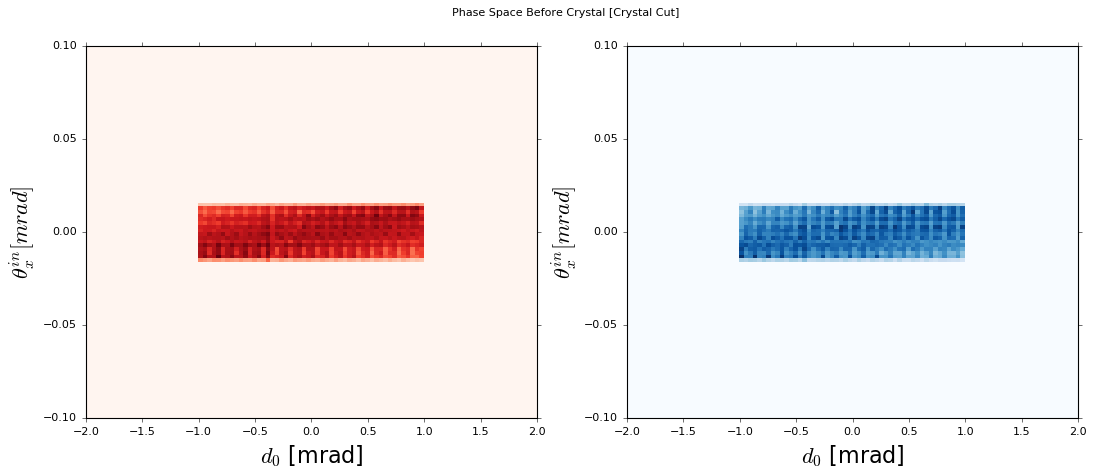

[[1.         0.08176592]
 [0.08176592 1.        ]]
0.5713192933010184 0.008430004746622475 0.9933143348532024 -1.2474785322807357e-06 -0.014999989440079974 0.01499999934095251 -0.0004269947392484152 -0.9999998543615978 0.9999995871724616
[[1.         0.08338091]
 [0.08338091 1.        ]]
0.5707202217242782 0.008403015519334808 0.9930476241381346 -2.0093227244725112e-06 -0.014999962958806495 0.014999988939408047 -0.00036136095530092937 -0.9999989222711588 0.9999999689365072
Emittance (RMS):  0.004800097522859512  -  0.004779070802562524


In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80)
plot2D(axes[0],dataset["d0_x"],dataset["thetaIn_x"],r"$d_0$ [mrad]",r"$\theta_{x}^{in} [mrad]$",
       (100,100),[[-2.,2.],[-0.1,0.1]],"Reds")
plot2D(axes[1],datasetSimu["d0_x"],datasetSimu["thetaIn_x"],r"$d_0$ [mrad]",r"$\theta_{x}^{in} [mrad]$",
       (100,100),[[-2.,2.],[-0.1,0.1]],"Blues")
fig.suptitle("Phase Space Before Crystal [Crystal Cut]")

plt.show()
print("Emittance (RMS): ",emittanceRMS(dataset["d0_x"],dataset["thetaIn_x"]),
    " - ",emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaIn_x"]))

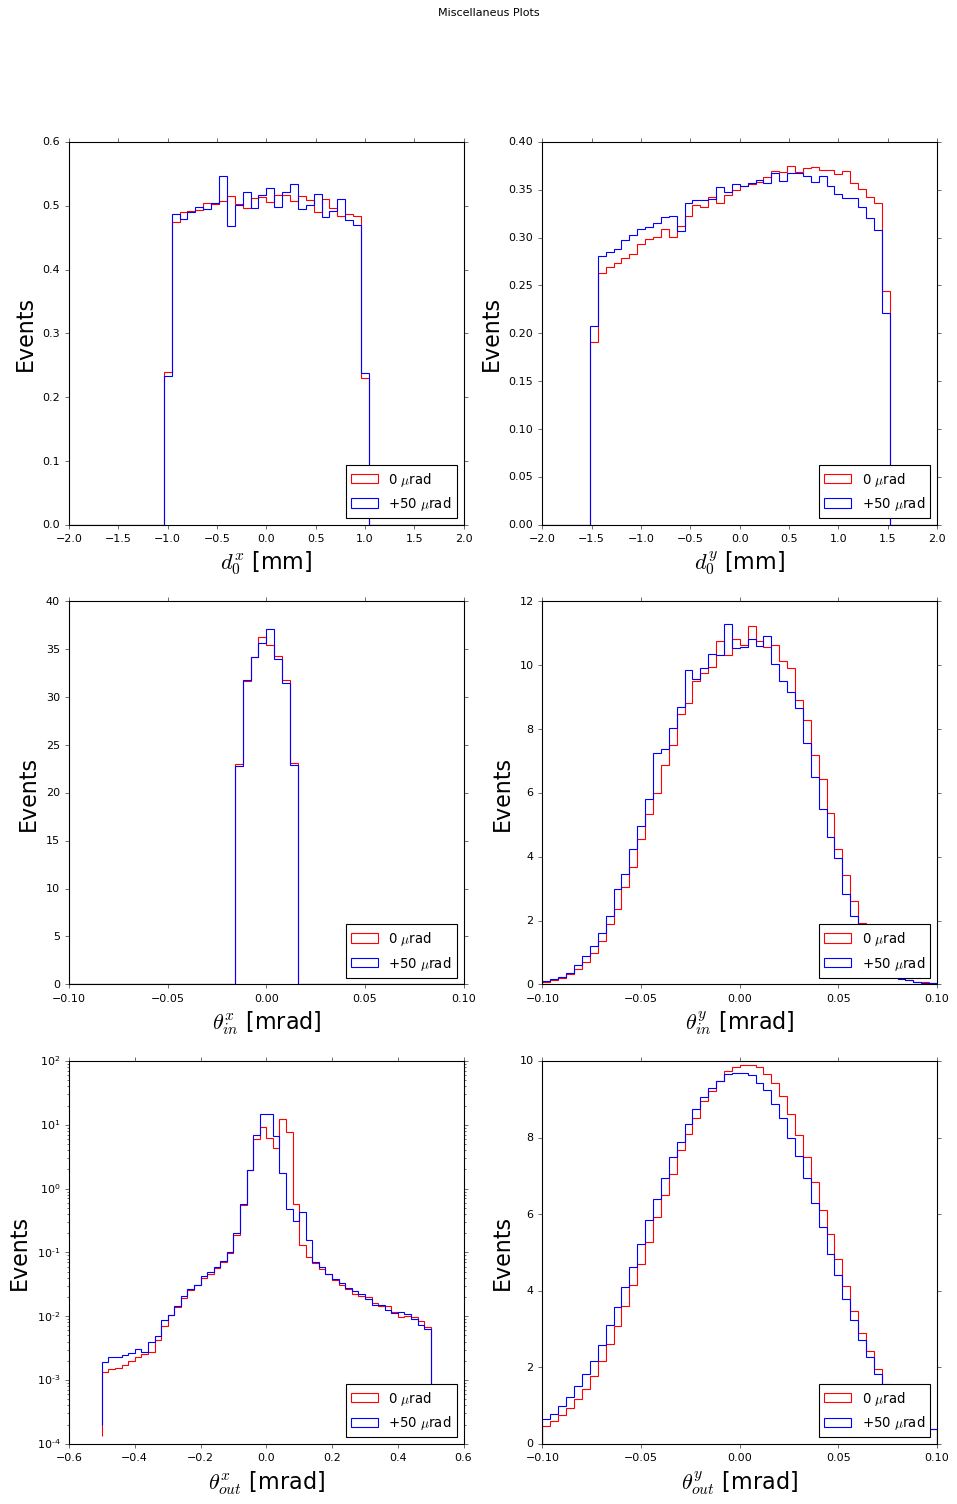

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(7*2, 7*3),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Miscellaneus Plots")


plot1DNorm(axes[0][0],dataset["d0_x"],inFileLabel,r"$d_0^{x}$ [mm]","Events",
       False,'r',50,[-2.,2.])
plot1DNorm(axes[0][0],datasetSimu["d0_x"],inSimFileLabel,r"$d_0^{x}$ [mm]","Events",
       False,'b',50,[-2.,2.])

plot1DNorm(axes[0][1],dataset["d0_y"],inFileLabel,r"$d_0^{y}$ [mm]","Events",
       False,'r',50,[-2.,2.])
plot1DNorm(axes[0][1],datasetSimu["d0_y"],inSimFileLabel,r"$d_0^{y}$ [mm]","Events",
       False,'b',50,[-2.,2.])

plot1DNorm(axes[1][0],dataset["thetaIn_x"],inFileLabel,r"$\theta_{in}^{x}$ [mrad]","Events",
       False,'r',50,[-0.1,0.1])
plot1DNorm(axes[1][0],datasetSimu["thetaIn_x"],inSimFileLabel,r"$\theta_{in}^{x}$ [mrad]","Events",
       False,'b',50,[-0.1,0.1])

plot1DNorm(axes[1][1],dataset["thetaIn_y"],inFileLabel,r"$\theta_{in}^{y}$ [mrad]","Events",
       False,'r',50,[-0.1,0.1])
plot1DNorm(axes[1][1],datasetSimu["thetaIn_y"],inSimFileLabel,r"$\theta_{in}^{y}$ [mrad]","Events",
       False,'b',50,[-0.1,0.1])

plot1DNorm(axes[2][0],dataset["thetaOut_x"],inFileLabel,r"$\theta_{out}^{x}$ [mrad]","Events",
       True,'r',50,[-0.5,0.5])
plot1DNorm(axes[2][0],datasetSimu["thetaOut_x"],inSimFileLabel,r"$\theta_{out}^{x}$ [mrad]","Events",
       True,'b',50,[-0.5,0.5])

plot1DNorm(axes[2][1],dataset["thetaOut_y"],inFileLabel,r"$\theta_{out}^{y}$ [mrad]","Events",
       False,'r',50,[-0.1,0.1])
plot1DNorm(axes[2][1],datasetSimu["thetaOut_y"],inSimFileLabel,r"$\theta_{out}^{y}$ [mrad]","Events",
       False,'b',50,[-0.1,0.1])

plt.show()


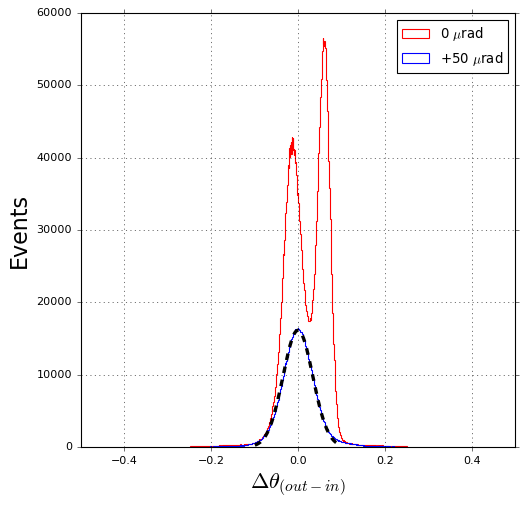

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 485
    # data points      = 200
    # variables        = 3
    chi-square         = 12861906.5
    reduced chi-square = 65288.8657
    Akaike info crit   = 2220.29263
    Bayesian info crit = 2230.18758
[[Variables]]
    amplitude:  1389.29968 +/- 3.45844088 (0.25%) (init = 1)
    center:    -4.0177e-04 +/- 9.8690e-05 (24.56%) (init = 0)
    sigma:      0.03436536 +/- 9.8963e-05 (0.29%) (init = 1)
    fwhm:       0.08092423 +/- 2.3304e-04 (0.29%) == '2.3548200*sigma'
    height:     16128.1732 +/- 40.1299556 (0.25%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.579


In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7, 7),dpi=80,facecolor='w', edgecolor='k')

commonBinWidth=0.001

plot1D(ax,dataset["deltaTheta"],inFileLabel,r"$\Delta\theta_{(out-in)}$","Events",
        False,'r',int(0.5/commonBinWidth),[-0.25,0.25])
plot1D(ax,datasetSimu["deltaTheta"],inSimFileLabel,r"$\Delta\theta_{(out-in)}$","Events",
        False,'b',int(0.5/commonBinWidth),[-0.25,0.25])

if False:
    param_bounds=([0,0,2.e-2], [3.5e3, 0.1, 0.07])
    data_entries, bins = np.histogram(datasetSimu["deltaTheta"])
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
#    popt, pcov = curve_fit(GaussFunc, xdata=binscenters, ydata=data_entries, p0=[len(datasetSimu), 0.0, 0.1])
    popt, pcov = curve_fit(gaus2, xdata=binscenters, ydata=data_entries, p0=[2500, 0.0, 0.04], bounds=param_bounds)
    #print(popt)
    xspace = np.linspace(-0.1, 0.1, 100000)
    #plt.plot(xspace, GaussFunc(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    plt.plot(xspace, gaus2(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    print(popt)

if True:
    from lmfit.models import GaussianModel
    data_entries, bins = np.histogram(datasetSimu[abs(datasetSimu.deltaTheta)<0.1]["deltaTheta"], bins=int(0.2/commonBinWidth))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    mod = GaussianModel()
   # mod.set_param_hint('sigma', min=0, max=0.2, value = 0.05, vary = True)
   # mod.set_param_hint('amplitude', min=0.1*len(temp), max=1.1*len(temp), value = len(temp))
   # mod.set_param_hint('center', min=0, max=0.1, value = 0, vary = True)

    pars = mod.guess(data_entries, x=data_entries)
    #out = mod.fit(data_entries, pars, x=data_entries, amplitude=230, center=0, sigma=0.04)
    out = mod.fit(data_entries.astype(float), x=binscenters.astype(float))
    plt.xlim(-.5, .5)
    plt.plot(binscenters, out.best_fit, 'k--', label='initial fit')
    plt.grid(True)
    plt.show()

    print(out.fit_report())


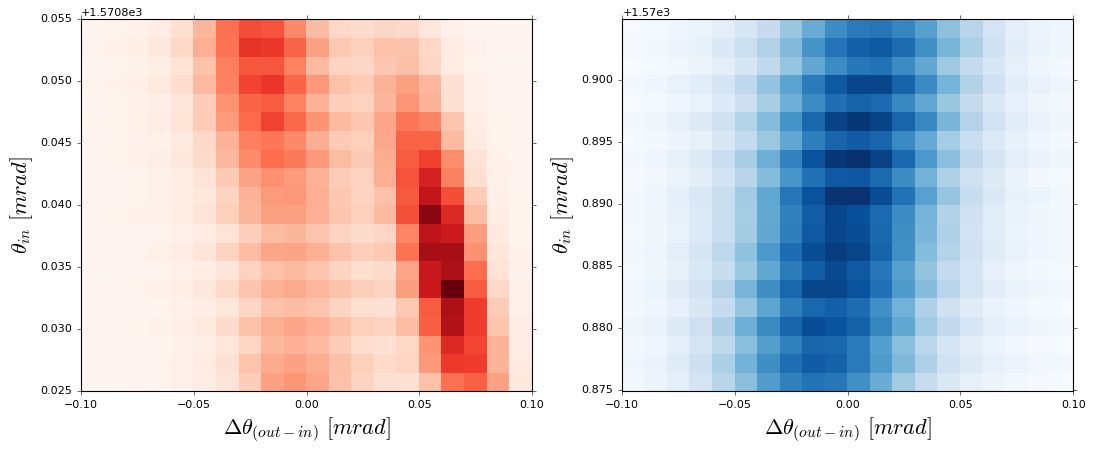

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80)
plot2D(axes[0],dataset["deltaTheta"],dataset["thetaIn_x"]+dataset["gonio_angle"],
       r"$\Delta\theta_{(out-in)} ~[mrad]$",r"$\theta_{in}~[mrad]$",(20,20),
       [[-.1,.1],[dataset.iloc[0]["gonio_angle"]-max_thetaInx,dataset.iloc[0]["gonio_angle"]+max_thetaInx]],
       "Reds")

plot2D(axes[1],datasetSimu["deltaTheta"],datasetSimu["thetaIn_x"]+datasetSimu["gonio_angle"],
       r"$\Delta\theta_{(out-in)} ~[mrad]$",r"$\theta_{in}~[mrad]$",(20,20),
       [[-.1,.1],[datasetSimu.iloc[0]["gonio_angle"]-max_thetaInx,datasetSimu.iloc[0]["gonio_angle"]+max_thetaInx]],
       "Blues")

plt.show()

In [13]:
#mimic the presence of the septum
septumAng = 0.03
print(septumAng)
#print(dataset["thetaOut_x"])
dataset = dataset[(dataset.thetaOut_x)>septumAng]
#print(dataset)

0.03


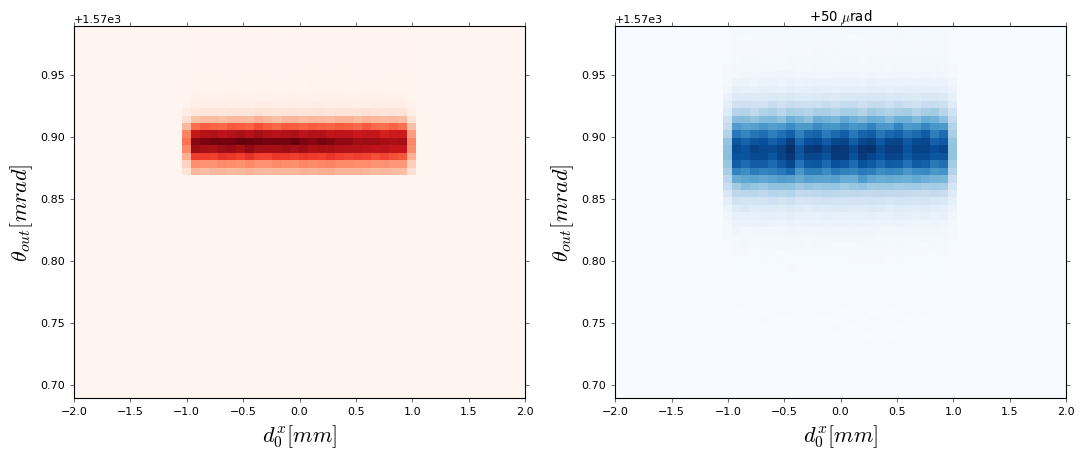

Emittance (RMS):  0.02886108161562236  -  0.03111084065452379


In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8*2, 6),dpi=80)
plot2D(axes[0],dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"],
       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
plt.title(inFileLabel,fontsize=20)

plot2D(axes[1],datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"],
       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Blues")

plt.title(inSimFileLabel)

plt.show()

print("Emittance (RMS): ",emittanceRMS(dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"]),
    " - ",emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"]))

fig.savefig("beams.pdf")

In [ ]:
print("Entries (evs,cols):",dataset.shape)
print(len(dataset))

In [ ]:
print(datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"])

In [ ]:
print(dataset["thetaOut_x"]+dataset["gonio_angle"])

((2110605,), 0          -0.118649
2           0.000000
3           0.000000
4           0.000000
6           0.973447
              ...   
14282856    0.392919
14282863   -0.759198
14282865    0.329519
14282874    0.804862
14282878   -0.040600
Name: d0_x, Length: 2110605, dtype: float64)


ValueError: too many values to unpack (expected 2)

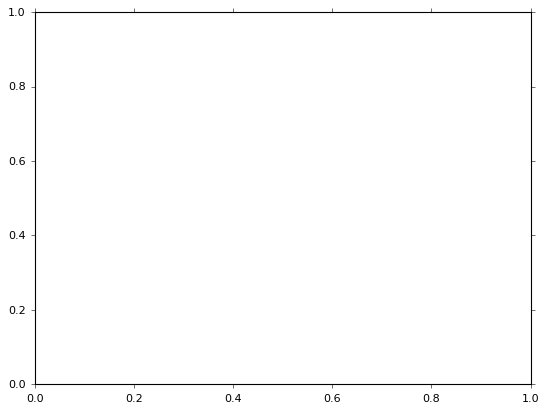

In [41]:
merged = dataset
merged.append(datasetSimu)

print((dataset["d0_x"].shape,dataset["d0_x"]))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plt.hist2d(np.array([dataset["d0_x"],dataset["d0_x"]]),
           np.array([dataset["thetaOut_x"]+dataset["gonio_angle"],dataset["thetaOut_x"]+dataset["gonio_angle"]]),label=['a','b'])

#    ax.set_xlabel(xlabel, fontsize='20')
#    ax.set_ylabel(ylabel, fontsize='20')
#plot2D(ax,dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
#plot2D(ax,datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"],
#       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
#       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Blues")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80)
plot2D(ax,merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"],
       r"$d_{0}^{x} [mm]$",r"$\theta_{out} [mrad]$",(50,50),
       [[-2.,2.], [-0.15+gonio_zero,0.15+gonio_zero]],"Reds")
plt.title("Recombined beam",fontsize=20)

plt.show()

print("Emittance (RMS): ",emittanceRMS(merged["d0_x"],merged["thetaOut_x"]+merged["gonio_angle"]))
